In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')


In [4]:
df = pd.read_excel('/kaggle/input/ecommerce-customer-churn-analysis-and-prediction/E Commerce Dataset.xlsx', sheet_name='E Comm')
print(df.shape)
df.head()

(5630, 20)


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


# About the Dataset

In [5]:
df.shape

(5630, 20)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

### Each row is a unique customer

In [7]:
df.CustomerID.nunique()

5630

### There is no duplicate row

In [8]:
df.duplicated().sum()

0

### Missing data

Text(0.5, 1.0, 'Percentage of Missing Data')

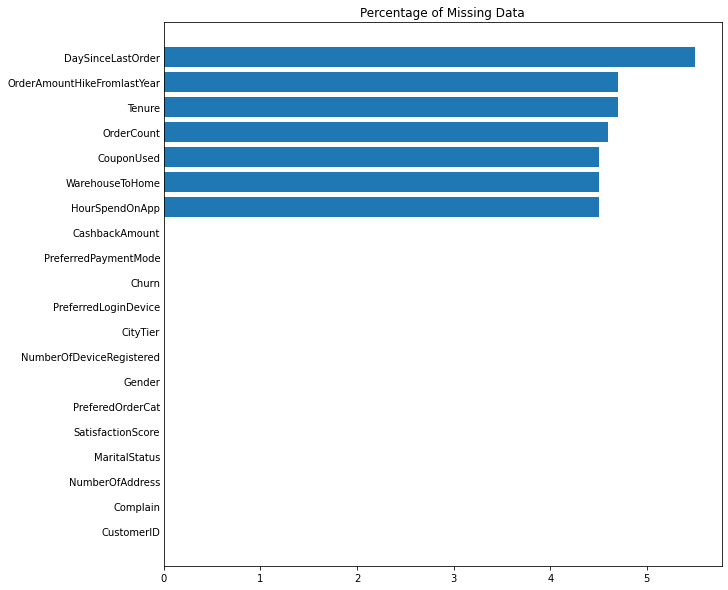

In [9]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': round(percent_missing,1)})
missing_value_df = missing_value_df.sort_values('percent_missing', ascending=True)
plt.figure(figsize=(10,10))
plt.barh(missing_value_df['column_name'],missing_value_df['percent_missing'])
plt.tick_params(axis='y', which='both',length=0)
plt.title('Percentage of Missing Data')

In [10]:
# Observe unique value for each column
# for i in df.columns:
#     print(i)
#     print(df[i].value_counts())
#     print()

# Cleaning

### Standardize categorical values for PreferredPaymentMode
- Eg. Some rows recorded 'CC', some 'Credit Card'

In [11]:
df['PreferredPaymentMode'].unique()

array(['Debit Card', 'UPI', 'CC', 'Cash on Delivery', 'E wallet', 'COD',
       'Credit Card'], dtype=object)

In [12]:
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].str.replace('Cash on Delivery','COD')
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].str.replace('Credit Card','CC')

In [13]:
# df = df.replace(' ', '_', regex=True)
# df = df.replace('&', 'And', regex=True)

### Categorize column types

In [14]:
binary_cat_cols = ['Complain']
outcome = ['Churn']
cat_cols = ['PreferredLoginDevice','Gender','PreferedOrderCat','MaritalStatus','CityTier']
num_cols = ['Tenure','WarehouseToHome','HourSpendOnApp','NumberOfDeviceRegistered','SatisfactionScore','NumberOfAddress','OrderAmountHikeFromlastYear',
           'CouponUsed','OrderCount','DaySinceLastOrder','CashbackAmount']

### Average proportion of Churn customers

In [15]:
df.Churn.mean()

0.16838365896980462

# Visualize 

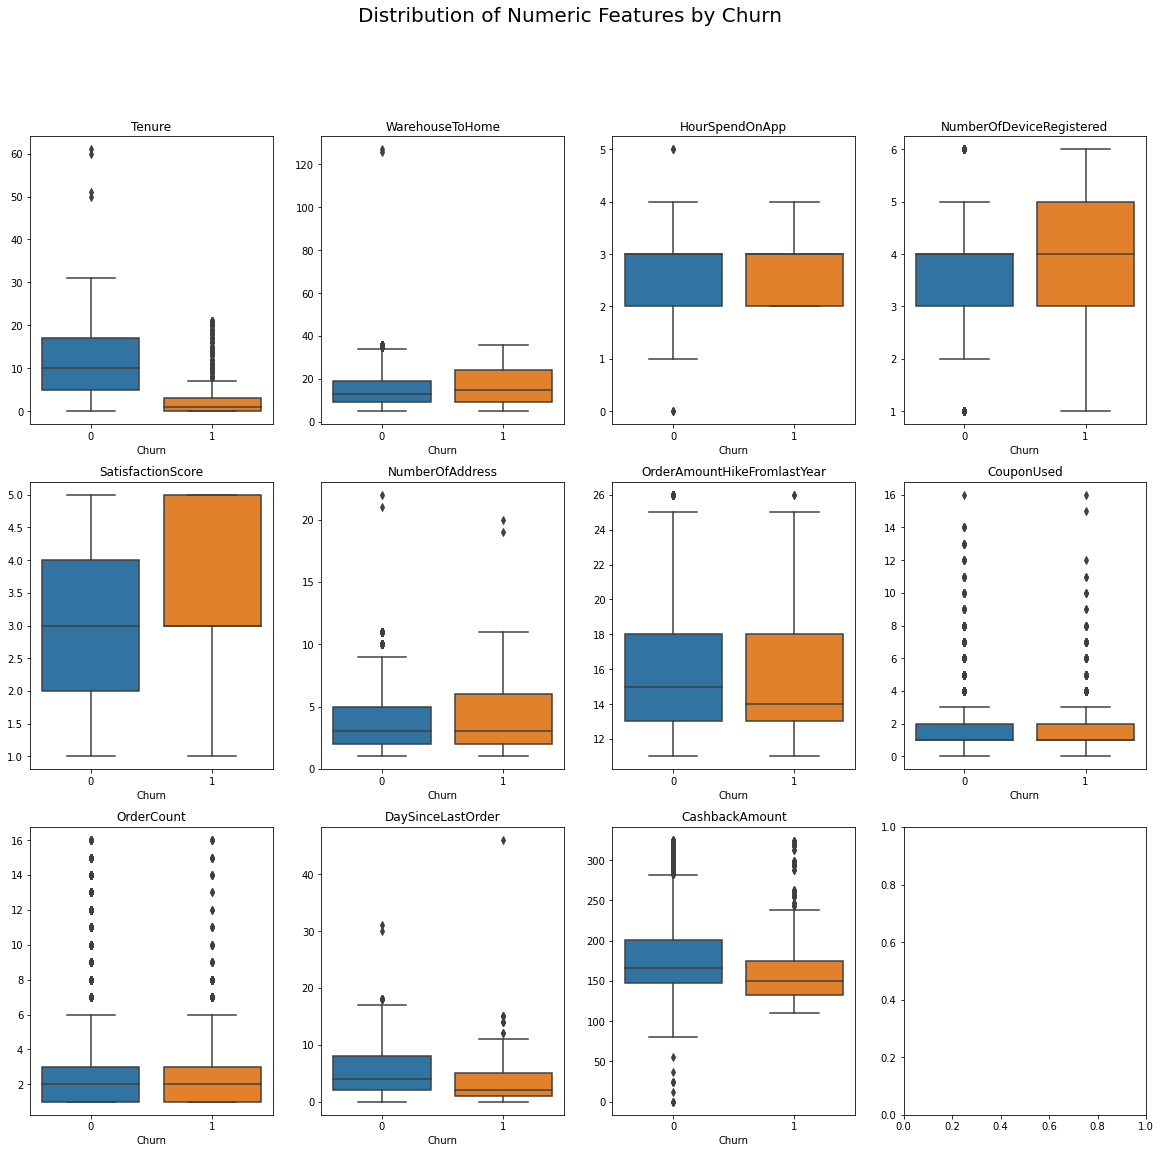

In [16]:
fig, ax = plt.subplots(3,4,figsize=(20, 18))
fig.suptitle('Distribution of Numeric Features by Churn', fontsize=20)
ax = ax.flatten()
for idx,c in enumerate(num_cols):
    df_t = df[df[c].notnull()].copy()
    ax[idx].set_title(c) 
    sns.boxplot(x='Churn', y=c, data=df_t, ax=ax[idx])
    ax[idx].set_ylabel('')
plt.show()

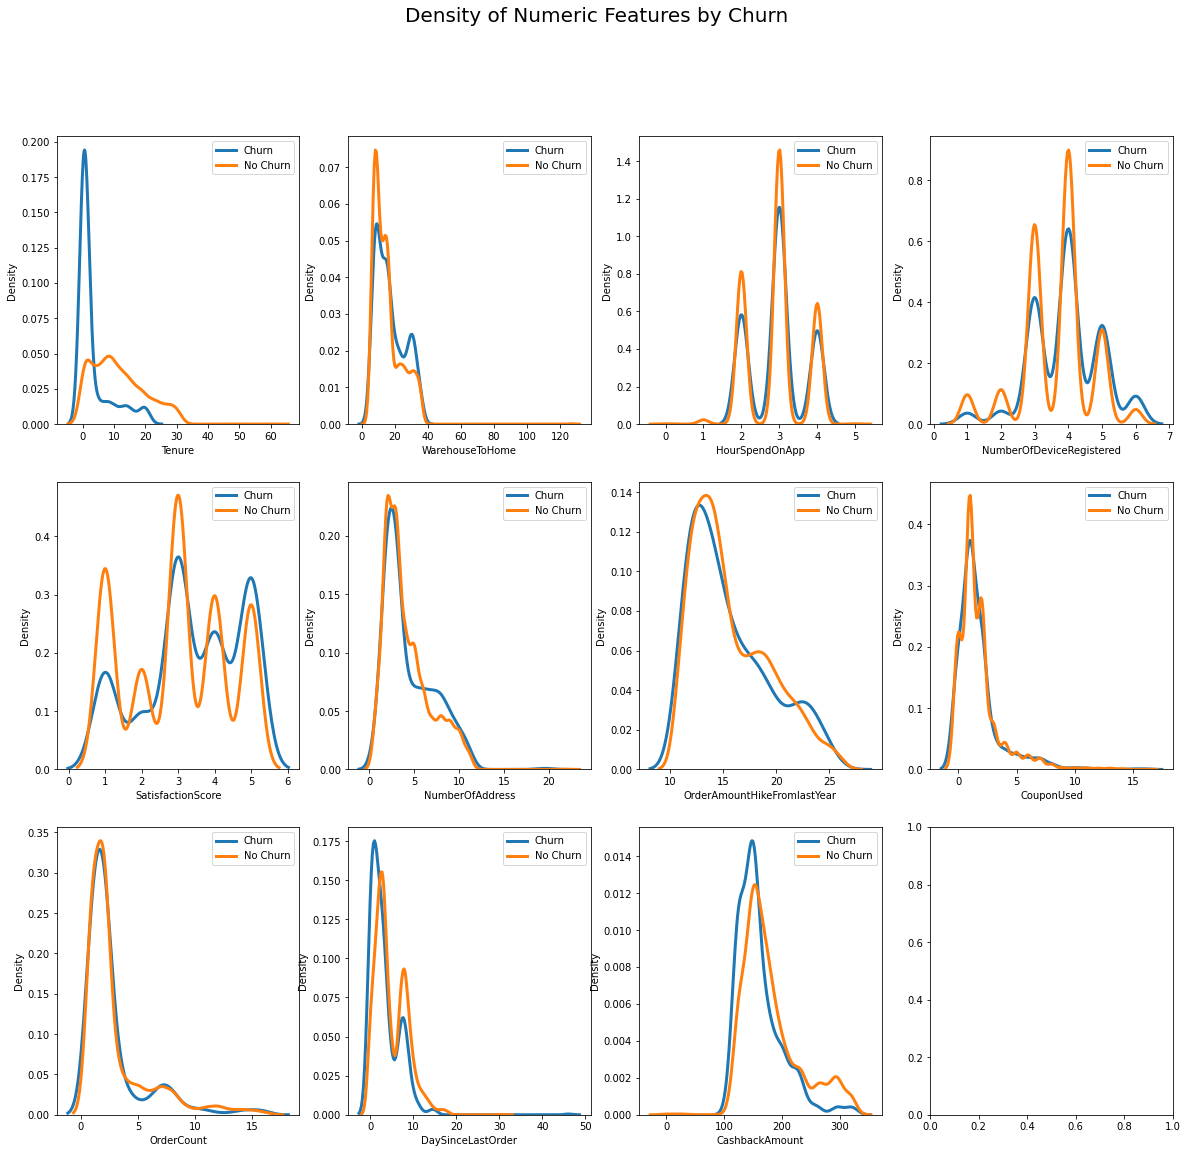

In [17]:
df_c = df[df['Churn']==1].copy()
df_nc = df[df['Churn']==0].copy()

fig, ax = plt.subplots(3,4,figsize=(20, 18))
fig.suptitle('Density of Numeric Features by Churn', fontsize=20)
ax = ax.flatten()

for idx,c in enumerate(num_cols):
    sns.kdeplot(df_c[c], linewidth= 3,
             label = 'Churn',ax=ax[idx])
    sns.kdeplot(df_nc[c], linewidth= 3,
             label = 'No Churn',ax=ax[idx])
    
    ax[idx].legend(loc='upper right')

plt.show()

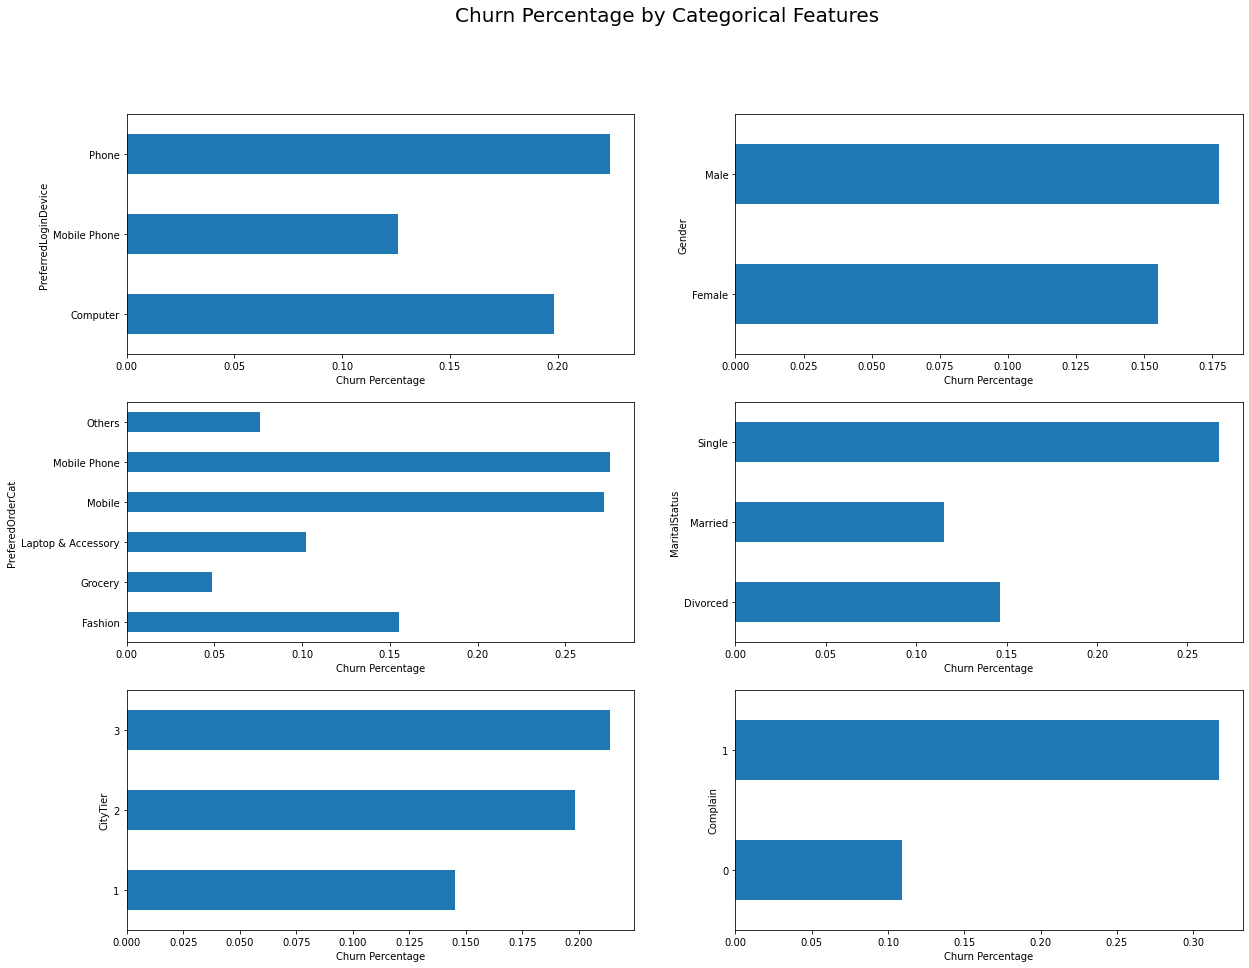

In [18]:
fig, ax = plt.subplots(3,2,figsize=(20, 15))
fig.suptitle('Churn Percentage by Categorical Features', fontsize=20)
ax = ax.flatten()

for idx,c in enumerate(cat_cols+binary_cat_cols):
    df.groupby(c).Churn.mean().plot.barh(ax=ax[idx])
    ax[idx].set_xlabel('Churn Percentage')
plt.show()

# Impute missing values

In [19]:
# impute with median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Remove Outliers

In [20]:
def remove_outlier(df, col):    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75) 
    IQR=Q3-Q1
    lr= Q1-(1.5 * IQR)
    ur= Q3+(1.5 * IQR)

    df[col]=np.where(df[col]>ur,ur,df[col])
    df[col]=np.where(df[col]<lr,lr,df[col])
    
    return df

for c in num_cols:
    df = remove_outlier(df, c)

In [21]:
# export data
df.to_csv('eCommerce.csv')

# One Hot Encode Categorical Features

### Remove space and special character

In [22]:
df = df.replace(' ', '_', regex=True)
df = df.replace('&', 'And', regex=True)

In [23]:
df_encoded = pd.get_dummies(df,drop_first=True)
df_encoded.columns

Index(['CustomerID', 'Churn', 'Tenure', 'CityTier', 'WarehouseToHome',
       'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore',
       'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount',
       'PreferredLoginDevice_Mobile_Phone', 'PreferredLoginDevice_Phone',
       'PreferredPaymentMode_COD', 'PreferredPaymentMode_Debit_Card',
       'PreferredPaymentMode_E_wallet', 'PreferredPaymentMode_UPI',
       'Gender_Male', 'PreferedOrderCat_Grocery',
       'PreferedOrderCat_Laptop_And_Accessory', 'PreferedOrderCat_Mobile',
       'PreferedOrderCat_Mobile_Phone', 'PreferedOrderCat_Others',
       'MaritalStatus_Married', 'MaritalStatus_Single'],
      dtype='object')

# Split Train Test Set
- Train set (80%)
- Test set (20%)

In [24]:
X = df_encoded[['Tenure', 'CityTier', 'WarehouseToHome',
       'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore',
       'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount',
       'PreferredLoginDevice_Mobile_Phone', 'PreferredLoginDevice_Phone',
       'PreferredPaymentMode_COD', 'PreferredPaymentMode_Debit_Card',
       'PreferredPaymentMode_E_wallet', 'PreferredPaymentMode_UPI',
       'Gender_Male', 'PreferedOrderCat_Grocery',
       'PreferedOrderCat_Laptop_And_Accessory', 'PreferedOrderCat_Mobile',
       'PreferedOrderCat_Mobile_Phone', 'PreferedOrderCat_Others',
       'MaritalStatus_Married', 'MaritalStatus_Single']].copy()
y = df_encoded['Churn']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state=42)

# Min-Max Scaling

In [25]:
# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

# Modeling

### Random Forest

In [26]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

print(type(rfc))
scores = cross_val_score(rfc,X_train,y_train,cv=5, scoring='roc_auc')
print ("CV score :",scores.mean())
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
print(classification_report(y_test, pred))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score : 0.9753447869882825
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       941
           1       0.99      0.85      0.92       185

    accuracy                           0.97      1126
   macro avg       0.98      0.92      0.95      1126
weighted avg       0.97      0.97      0.97      1126



### Logistic Regression

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, pred),annot=True,fmt = "d",linecolor="k",linewidths=3)    
plt.title("Random forest CONFUSION MATRIX",fontsize=14)
plt.show()

print('-'*60)

y_pred_prob = rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(12, 8))

plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr, tpr, label='Logistic Regression',color = "b")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest ',fontsize=16)
plt.show();

NameError: name 'confusion_matrix' is not defined

<Figure size 576x432 with 0 Axes>

In [28]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

print(type(lr))
scores = cross_val_score(lr,X_train,y_train,cv=5,scoring='roc_auc')
print ("CV score :",scores.mean())
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print(classification_report(y_test, pred))

<class 'sklearn.linear_model._logistic.LogisticRegression'>
CV score : 0.8789789771270087
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       941
           1       0.79      0.53      0.63       185

    accuracy                           0.90      1126
   macro avg       0.85      0.75      0.79      1126
weighted avg       0.89      0.90      0.89      1126



### Random Forest performs better than Logistic Regression
- Fine tune hyper parameters for Random Forest

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


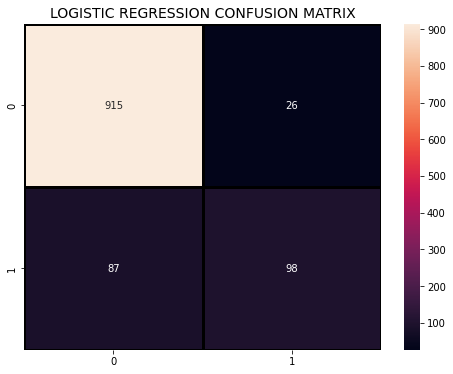

------------------------------------------------------------


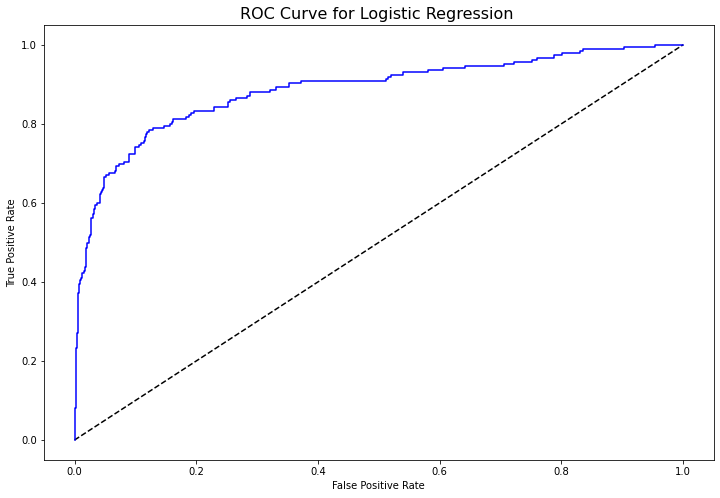

In [30]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, pred),annot=True,fmt = "d",linecolor="k",linewidths=3)    
plt.title("LOGISTIC REGRESSION CONFUSION MATRIX",fontsize=14)
plt.show()

print('-'*60)

y_pred_prob = lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(12, 8))

plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr, tpr, label='Logistic Regression',color = "b")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression ',fontsize=16)
plt.show();

Light GBM Classifier 0.9698046181172292
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       941
           1       0.95      0.86      0.90       185

    accuracy                           0.97      1126
   macro avg       0.96      0.93      0.94      1126
weighted avg       0.97      0.97      0.97      1126



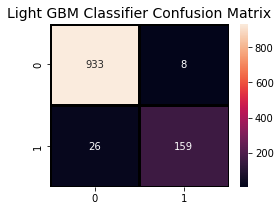

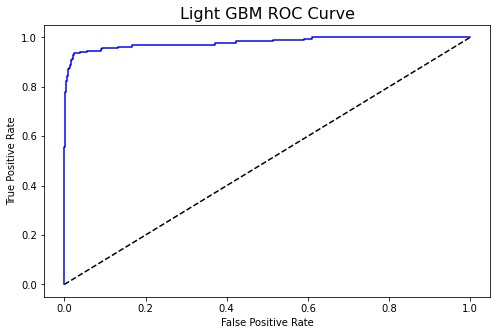

In [36]:
from lightgbm import LGBMClassifier

lgbm= LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.5, max_depth=7, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
                        n_jobs=-1, num_leaves=500, objective='binary', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)
lgbm=LGBMClassifier()

lgbm.fit(X_train,y_train)
lgbm_pred = lgbm.predict(X_test)
print("Light GBM Classifier", accuracy_score(y_test, lgbm_pred))

print(classification_report(y_test, lgbm_pred))


plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, lgbm_pred),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("Light GBM Classifier Confusion Matrix",fontsize=14)
plt.show()
y_lgbmpred_prob = lgbm.predict_proba(X_test)[:,1]
fpr_lgbm, tpr_lgbm, thresholds = roc_curve(y_test, y_lgbmpred_prob)
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_lgbm, tpr_lgbm, label='Light GBM',color = "b")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Light GBM ROC Curve',fontsize=16)
plt.show();


XGBoost Classifier 0.977797513321492
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       941
           1       0.97      0.90      0.93       185

    accuracy                           0.98      1126
   macro avg       0.97      0.95      0.96      1126
weighted avg       0.98      0.98      0.98      1126



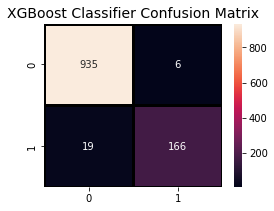

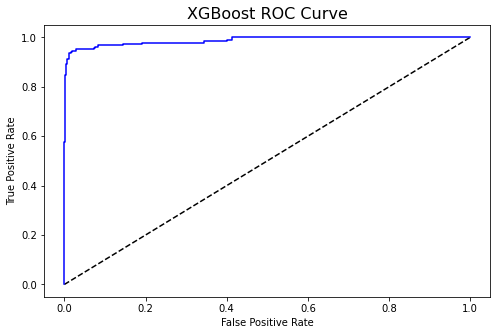

In [37]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("XGBoost Classifier", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, xgb_pred),
            annot=True, fmt="d", linecolor="k", linewidths=3)
    
plt.title("XGBoost Classifier Confusion Matrix", fontsize=14)
plt.show()
y_xgbpred_prob = xgb_model.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_xgbpred_prob)
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost',color = "b")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve',fontsize=16)
plt.show();


K-Nearest Neighbors Classifier 0.8747779751332149
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       941
           1       0.67      0.46      0.55       185

    accuracy                           0.87      1126
   macro avg       0.79      0.71      0.74      1126
weighted avg       0.86      0.87      0.87      1126



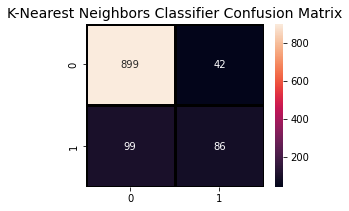

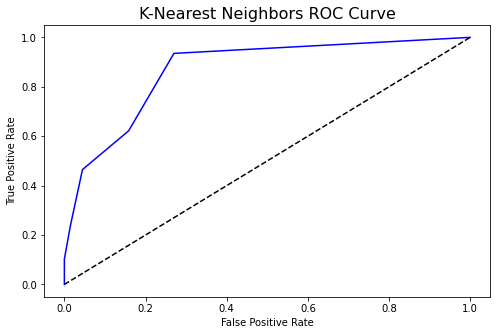

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
# K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

print("K-Nearest Neighbors Classifier", accuracy_score(y_test, knn_pred))
print(classification_report(y_test, knn_pred))

plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, knn_pred),
            annot=True, fmt="d", linecolor="k", linewidths=3)

plt.title("K-Nearest Neighbors Classifier Confusion Matrix", fontsize=14)
plt.show()

y_knnpred_prob = knn_model.predict_proba(X_test)[:,1]
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_knnpred_prob)
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_knn, tpr_knn, label='K-Nearest Neighbors', color="b")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Nearest Neighbors ROC Curve', fontsize=16)
plt.show();

SVM accuracy is : 0.8357015985790408
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       941
           1       0.00      0.00      0.00       185

    accuracy                           0.84      1126
   macro avg       0.42      0.50      0.46      1126
weighted avg       0.70      0.84      0.76      1126

------------------------------------------------------------


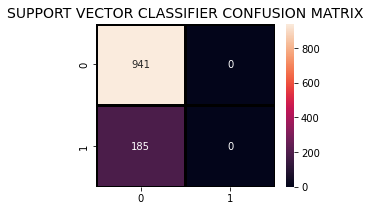

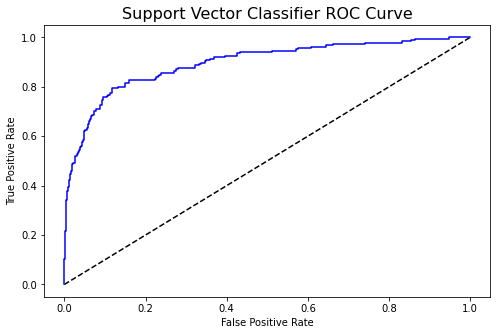

In [46]:
svc_model = SVC()
svc_model.fit(X_train,y_train)
predict_y = svc_model.predict(X_test)
accuracy_svc = svc_model.score(X_test,y_test)
print("SVM accuracy is :",accuracy_svc)
print('-'*60)
print(classification_report(y_test, predict_y))
print('-'*60)
plt.figure(figsize=(4,3))

sns.heatmap(confusion_matrix(y_test, predict_y),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("SUPPORT VECTOR CLASSIFIER CONFUSION MATRIX",fontsize=14)
plt.show()
y_svc_decision = svc_model.decision_function(X_test)
fpr_svc, tpr_svc, thresholds = roc_curve(y_test, y_svc_decision)
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_svc, tpr_svc, label='Support Vector Classifier', color="b")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Support Vector Classifier ROC Curve', fontsize=16)
plt.show();



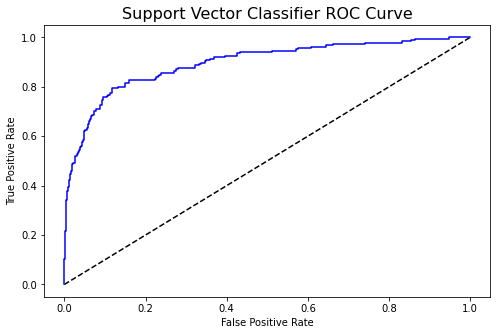

Decision Tree Classifier 0.9626998223801065
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       941
           1       0.87      0.90      0.89       185

    accuracy                           0.96      1126
   macro avg       0.93      0.94      0.93      1126
weighted avg       0.96      0.96      0.96      1126



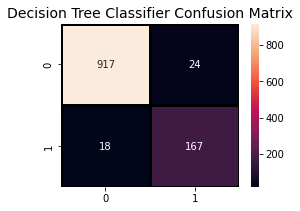

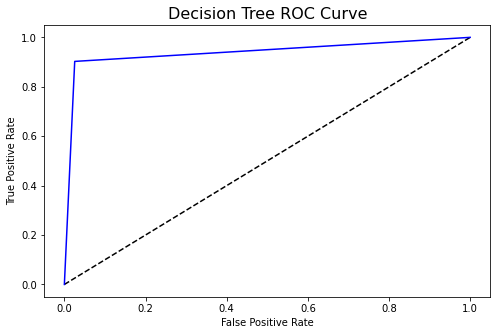

In [47]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

print("Decision Tree Classifier", accuracy_score(y_test, dt_pred))
print(classification_report(y_test, dt_pred))

plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, dt_pred),
annot=True, fmt="d", linecolor="k", linewidths=3)

plt.title("Decision Tree Classifier Confusion Matrix", fontsize=14)
plt.show()

y_dtpred_prob = dt_model.predict_proba(X_test)[:,1]
fpr_dt, tpr_dt, thresholds = roc_curve(y_test, y_dtpred_prob)
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_dt, tpr_dt, label='Decision Tree', color="b")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve', fontsize=16)
plt.show();

In [39]:
gs_rfc = GridSearchCV(RandomForestClassifier(random_state=42), {'max_depth': [2, 5, 8, 10, 12, 15, 20, 30, 50],
                                                 'n_estimators': [5, 10, 20, 30, 50, 100,200]},
                      verbose=1, cv=5) # make sure cv condition same as actual fitting for training set

gs_rfc.fit(X_train, y_train)

# select the best estimator
print('Best score:', gs_rfc.best_score_, '(Not much different from default parameters)')
print('Best parameters:', gs_rfc.best_params_)


Fitting 5 folds for each of 63 candidates, totalling 315 fits


KeyboardInterrupt: 

### Adding categorical features did not improve performance

# Feature Selection
- Observe how number of features affect prediction performance

In [32]:
rfecv = RFECV(estimator=RandomForestClassifier(random_state=42),
             step=1,
             cv=5,
              scoring='roc_auc')

# [Checked] Adding categorical features did not improve performance
rfecv.fit(X_train, y_train)

RFECV(cv=5, estimator=RandomForestClassifier(random_state=42),
      scoring='roc_auc')

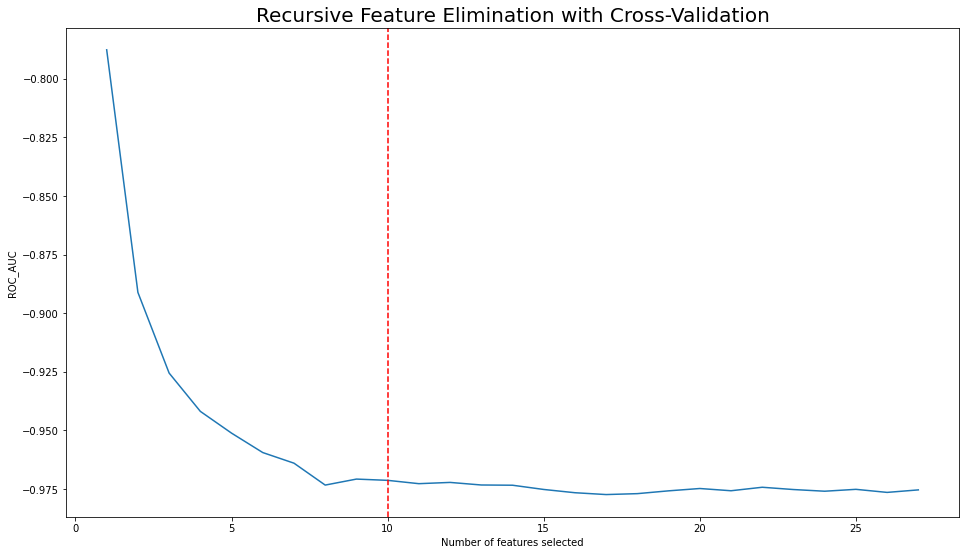

In [33]:
plt.figure(figsize=(16,9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=20)
plt.xlabel('Number of features selected')
plt.ylabel('ROC_AUC')
plt.plot(range(1,len(rfecv.grid_scores_)+1), [-i.mean() for i in rfecv.grid_scores_])
plt.axvline(x = 10, color = 'r', linestyle='dashed')
plt.show()

# 10 features seems sufficient, more features does not significantly improve performance

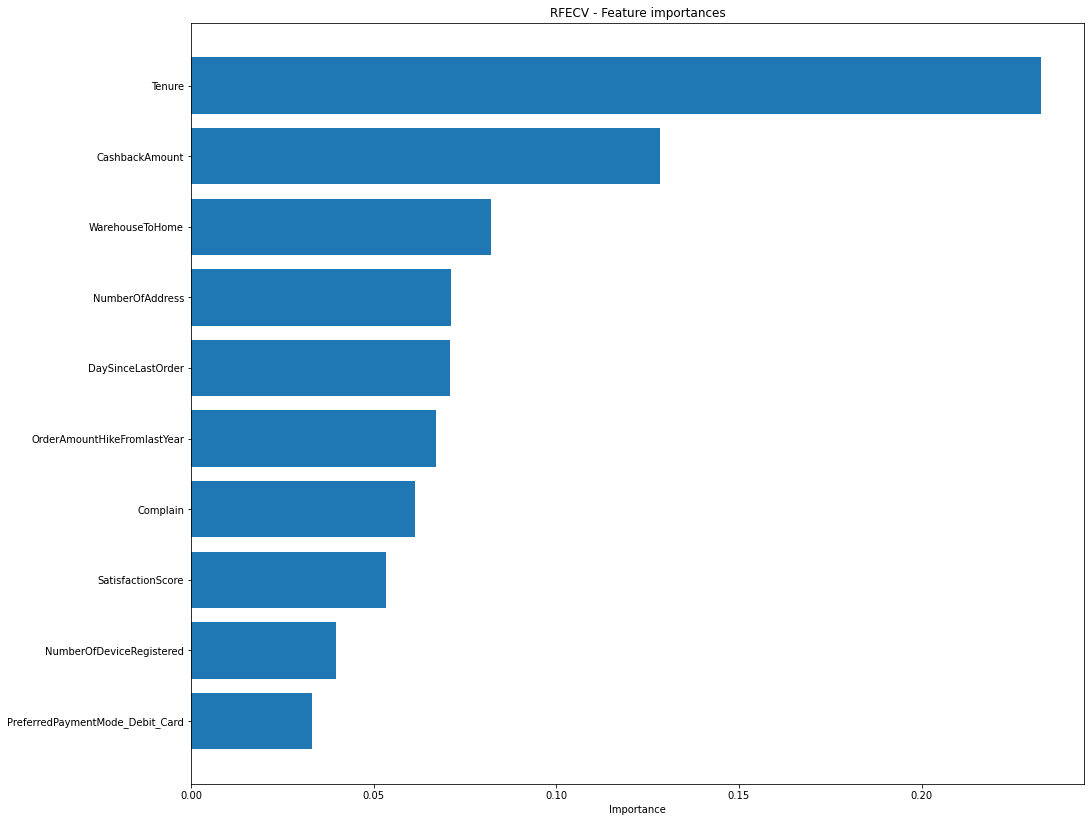

In [34]:
dset = pd.DataFrame()
dset['attr'] = list(X_train.columns)[:len(rfecv.estimator_.feature_importances_)]
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance',ascending=True).tail(10)


plt.figure(figsize=(16,14))
plt.barh(y=dset['attr'],width=dset['importance'])
plt.title('RFECV - Feature importances')
plt.xlabel('Importance')
plt.show()

In [35]:
selected_cols = list(dset['attr'])
rfc = RandomForestClassifier(random_state=42)

print(type(rfc))
scores = cross_val_score(rfc,X_train[selected_cols],y_train,cv=5, scoring='roc_auc')
print ("CV score :",scores.mean())
rfc.fit(X_train[selected_cols], y_train)
pred = rfc.predict(X_test[selected_cols])
print(classification_report(y_test, pred))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score : 0.973522539688213
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       941
           1       0.98      0.88      0.93       185

    accuracy                           0.98      1126
   macro avg       0.98      0.94      0.96      1126
weighted avg       0.98      0.98      0.98      1126

